In [ ]:
import numpy as np
import os
import joblib
from sklearn.metrics import mean_squared_error

# --- CONFIGURAZIONE ---
MODEL_PATH = "../models/hybrid_models/best_decision_tree_spy.pkl" 
X_TEST_PATH = "C:/Users/angel/OneDrive/Desktop/ProgettoMeDL/Financial_Forecasting_XAI/data_split_titolo/X_test.npy"
Y_TEST_PATH = "C:/Users/angel/OneDrive/Desktop/ProgettoMeDL/Financial_Forecasting_XAI/data_split_titolo/y_test.npy"

feats_technical = ['volume', 'open', 'high', 'low', 'close', 'adj close']
feats_sentiment = ['volume', 'open', 'high', 'low', 'close', 'adj close', 'sentiment_score']

# --- CARICAMENTO ---
print(f"Caricamento Decision Tree: {os.path.basename(MODEL_PATH)}...")
# CORREZIONE: Usa joblib invece di load_model
model = joblib.load(MODEL_PATH) 

X_test = np.load(X_TEST_PATH)
y_test = np.load(Y_TEST_PATH)

# --- DETEZIONE FEATURES ---
# Sklearn non ha input_shape facile da leggere. 
# Usiamo il numero di feature su cui è stato fittato (n_features_in_)
# Ma attenzione: n_features_in_ sarà (60 * n_features).
# Dobbiamo dedurlo o provare.
n_inputs_expected = model.n_features_in_
print(f"Il modello si aspetta {n_inputs_expected} input totali (appiattiti).")

# Calcolo inverso: 360 input / 60 step = 6 features. 420 input / 60 step = 7 features.
num_features_calc = int(n_inputs_expected / 60)
print(f"Feature calcolate: {num_features_calc}")

if num_features_calc == 6:
    print(">>> MODALITÀ: SOLO DATI TECNICI")
    X_test_ready = X_test[:, :, :-1]
    feature_list = feats_technical
elif num_features_calc == 7:
    print(">>> MODALITÀ: TECNICI + SENTIMENT")
    X_test_ready = X_test
    feature_list = feats_sentiment
else:
    raise ValueError(f"Numero feature calcolato strano: {num_features_calc}")

# --- CALCOLO PERMUTATION IMPORTANCE ---
print("-" * 50)
print(f"{'FEATURE':<20} | {'IMPORTANCE (Aumento MSE)':<25}")
print("-" * 50)

# Funzione helper per appiattire e predire
def predict_dt(data_3d):
    nsamples, nx, ny = data_3d.shape
    data_flat = data_3d.reshape((nsamples, nx*ny))
    return model.predict(data_flat)

# Errore base
mse_base = mean_squared_error(y_test, predict_dt(X_test_ready))

for i in range(len(feature_list)):
    feature_name = feature_list[i]
    X_permuted = X_test_ready.copy()
    
    # Permutazione: Mescoliamo la colonna 'i' per tutti i timestep
    # Manteniamo la coerenza temporale? Permutation importance standard mescola i campioni.
    np.random.shuffle(X_permuted[..., i])
    
    mse_perm = mean_squared_error(y_test, predict_dt(X_permuted))
    
    importance = mse_perm - mse_base
    print(f"{feature_name:<20} | {importance:.6f}")

Caricamento Decision Tree: best_decision_tree_spy.pkl...
Il modello si aspetta 420 input totali (appiattiti).
Feature calcolate: 7
>>> MODALITÀ: TECNICI + SENTIMENT
--------------------------------------------------
FEATURE              | IMPORTANCE (Aumento MSE) 
--------------------------------------------------
volume               | 0.000007
open                 | -0.000057
high                 | 0.000771
low                  | -0.000158
close                | 0.004138
adj close            | 0.000719
sentiment_score      | 0.000054


# SHAP


In [1]:
import shap
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

# CORREZIONE: Rimuoviamo run_functions_eagerly che causa problemi
# Invece, gestiamo il predict con batch_size esplicito

# --- CONFIGURAZIONE ---
class Config:
    """Configurazione centralizzata per l'analisi SHAP"""
    # Scegli il modello da analizzare
    MODEL_PATH = "../models/hybrid_models/best_lstm_spy_model.keras" 
    # MODEL_PATH = "../models/hybrid_models/best_cnn_spy_model.keras"
    # MODEL_PATH = "../models/hybrid_models/best_decision_tree_spy.pkl"
    
    X_TRAIN_PATH = "C:/Users/angel/OneDrive/Desktop/ProgettoMeDL/Financial_Forecasting_XAI/data_split_titolo/X_train.npy"
    X_TEST_PATH = "C:/Users/angel/OneDrive/Desktop/ProgettoMeDL/Financial_Forecasting_XAI/data_split_titolo/X_test.npy"
    
    FEATURES_TECHNICAL = ['volume', 'open', 'high', 'low', 'close', 'adj close']
    FEATURES_WITH_SENTIMENT = ['volume', 'open', 'high', 'low', 'close', 'adj close', 'sentiment']
    
    # Parametri SHAP
    N_BACKGROUND_SAMPLES = 60  
    N_TEST_SAMPLES = 10          
    N_SHAP_SAMPLES = 100        

# --- FUNZIONI UTILITY ---
def load_data(config):
    """Carica i dati di training e test"""
    print(f"Caricamento dati da:\n  - {os.path.basename(config.X_TRAIN_PATH)}\n  - {os.path.basename(config.X_TEST_PATH)}")
    X_train = np.load(config.X_TRAIN_PATH)
    X_test = np.load(config.X_TEST_PATH)
    print(f"Shape dati - Train: {X_train.shape}, Test: {X_test.shape}")
    return X_train, X_test

def identify_model_type(model_path, model):
    """Identifica il tipo di modello e le feature attese"""
    if model_path.endswith('.pkl'):
        # Decision Tree
        model_type = 'tree'
        expected_features = int(model.n_features_in_ / 60)
        input_shape = (60, expected_features)
    else:
        # Keras (LSTM o CNN)
        input_shape = model.input_shape
        
        if len(input_shape) == 3:  # (Batch, Steps, Features)
            model_type = 'lstm'
            expected_features = input_shape[-1]
        elif len(input_shape) == 4:  # (Batch, Steps, Features, Channels)
            model_type = 'cnn'
            expected_features = input_shape[-2]
        else:
            raise ValueError(f"Shape modello sconosciuta: {input_shape}")
    
    print(f"Tipo modello: {model_type.upper()}")
    print(f"Feature attese: {expected_features}")
    
    return model_type, expected_features, input_shape

def prepare_data(X_train, X_test, expected_features, config):
    """Prepara i dati in base al numero di feature attese"""
    if expected_features == 6:
        print(">>> MODALITÀ: SOLO DATI TECNICI (Rimozione Sentiment)")
        X_train_ready = X_train[:, :, :-1]
        X_test_ready = X_test[:, :, :-1]
        feature_names = config.FEATURES_TECHNICAL
    elif expected_features == 7:
        print(">>> MODALITÀ: TECNICI + SENTIMENT")
        X_train_ready = X_train
        X_test_ready = X_test
        feature_names = config.FEATURES_WITH_SENTIMENT
    else:
        raise ValueError(f"Numero di feature non supportato: {expected_features}")
    
    print(f"Shape dati preparati - Train: {X_train_ready.shape}, Test: {X_test_ready.shape}")
    
    return X_train_ready, X_test_ready, feature_names

def create_predict_wrapper(model, model_type, expected_features):
    """Crea wrapper per predizioni con gestione corretta dei batch"""
    def predict_wrapper(data_flat):
        # Converti a numpy array se necessario
        if not isinstance(data_flat, np.ndarray):
            data_flat = np.array(data_flat)
        
        # Gestisci il caso di singolo campione
        if len(data_flat.shape) == 1:
            data_flat = data_flat.reshape(1, -1)
        
        # Ricostruzione shape originale
        if model_type == 'lstm':
            data_reshaped = data_flat.reshape(data_flat.shape[0], 60, expected_features)
        elif model_type == 'cnn':
            data_reshaped = data_flat.reshape(data_flat.shape[0], 60, expected_features, 1)
        else:  # tree
            return model.predict(data_flat).flatten()
        
        # CORREZIONE: Usa predict con batch_size esplicito e verbose=0
        # Gestisci sia singoli campioni che batch
        try:
            predictions = model(data_reshaped, training=False).numpy()
            return predictions.flatten()
        except:
            # Fallback al metodo predict standard
            predictions = model.predict(data_reshaped, batch_size=len(data_reshaped), verbose=0)
            return predictions.flatten()
    
    return predict_wrapper

def generate_temporal_names(feature_names, n_steps=60):
    """Genera nomi feature tipo Close_t-1, Close_t-2 per il paper"""
    flat_names = []
    # Assumiamo indice 0 = t-60 (più vecchio) e indice 59 = t-1 (più recente)
    for t in range(n_steps):
        lag = n_steps - t  # Es. step 59 -> lag 1 (t-1)
        for feat in feature_names:
            flat_names.append(f"{feat}_t-{lag}")
    return flat_names

def compute_shap_values(model, model_type, expected_features, X_train_ready, X_test_ready, config):
    """Calcola i valori SHAP usando KernelExplainer"""
    
    # Appiattimento dei dati
    print("\nAppiattimento dei dati per KernelExplainer...")
    X_train_flat = X_train_ready.reshape(X_train_ready.shape[0], -1)
    X_test_flat = X_test_ready.reshape(X_test_ready.shape[0], -1)
    
    # Selezione campioni
    background = X_train_flat[:config.N_BACKGROUND_SAMPLES]
    test_samples = X_test_flat[:config.N_TEST_SAMPLES]
    
    print(f"Background dataset: {background.shape}")
    print(f"Test samples: {test_samples.shape}")
    
    # Creazione wrapper
    predict_wrapper = create_predict_wrapper(model, model_type, expected_features)
    
    # TEST DEL WRAPPER
    print("\nTest del wrapper di predizione...")
    try:
        test_pred = predict_wrapper(test_samples[:2])
        print(f"✓ Wrapper funziona! Output shape: {test_pred.shape}")
        print(f"  Sample predictions: {test_pred}")
    except Exception as e:
        print(f"✗ Errore nel wrapper: {e}")
        raise
    
    # Creazione explainer
    print("\n" + "="*60)
    print("Inizializzazione SHAP KernelExplainer...")
    print("="*60)
    
    explainer = shap.KernelExplainer(predict_wrapper, background)
    
    # Calcolo valori SHAP
    print(f"\nCalcolo valori SHAP per {len(test_samples)} campioni...")
    print("(Questo può richiedere alcuni minuti...)")
    
    shap_values = explainer.shap_values(test_samples, nsamples=config.N_SHAP_SAMPLES)
    
    # Gestione del formato output
    if isinstance(shap_values, list):
        shap_values = shap_values[0]
    
    print(f"✓ Shape valori SHAP calcolati: {shap_values.shape}")
    
    return shap_values, test_samples

def plot_shap_results(shap_values, test_samples, feature_names, config):
    """Genera i plot fedeli al paper (con dettaglio temporale)"""
    
    print("\nGenerazione feature names temporali (t-1, t-2...)...")
    temporal_feature_names = generate_temporal_names(feature_names, n_steps=60)
    
    print(f"Generazione SHAP summary plot dettagliato ({len(temporal_feature_names)} features)...")
    
    # Plot 1: Beeswarm plot dettagliato
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values, 
        test_samples, 
        feature_names=temporal_feature_names,
        max_display=20, 
        show=False
    )
    plt.title("SHAP Feature Importance (Dettaglio Temporale - Fedele al Paper)")
    plt.tight_layout()
    plt.savefig('shap_summary_temporal_faithful.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✓ Plot salvato: shap_summary_temporal_faithful.png")
    
    # Plot 2: Bar plot per importanza media
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values, 
        test_samples, 
        feature_names=temporal_feature_names,
        plot_type="bar",
        max_display=20,
        show=False
    )
    plt.title("SHAP Mean Absolute Value (Top 20 Features)")
    plt.tight_layout()
    plt.savefig('shap_bar_plot.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✓ Plot salvato: shap_bar_plot.png")
    
    # Analisi aggregata per feature (media su tutti i timesteps)
    print("\nCalcolo importanza aggregata per feature...")
    n_features = len(feature_names)
    shap_reshaped = shap_values.reshape(shap_values.shape[0], 60, n_features)
    shap_aggregated = np.abs(shap_reshaped).mean(axis=(0, 1))  # Media su samples e timesteps
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, shap_aggregated)
    plt.xlabel('Mean |SHAP value| (aggregated over time)')
    plt.title('Feature Importance (Aggregated Across All Timesteps)')
    plt.tight_layout()
    plt.savefig('shap_aggregated_features.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✓ Plot salvato: shap_aggregated_features.png")
    
    # Stampa ranking
    print("\n" + "="*60)
    print("RANKING FEATURE IMPORTANCE (Aggregato)")
    print("="*60)
    feature_importance = sorted(zip(feature_names, shap_aggregated), key=lambda x: x[1], reverse=True)
    for i, (feat, importance) in enumerate(feature_importance, 1):
        print(f"{i}. {feat:15s}: {importance:.6f}")

# --- MAIN ---
def main():
    config = Config()
    
    print("="*60)
    print("ANALISI SHAP PER MODELLI DI FORECASTING FINANZIARIO")
    print("="*60)
    
    # Caricamento dati
    X_train, X_test = load_data(config)
    
    # Caricamento modello
    print(f"\nCaricamento modello: {os.path.basename(config.MODEL_PATH)}...")
    if config.MODEL_PATH.endswith('.pkl'):
        model = joblib.load(config.MODEL_PATH)
    else:
        model = load_model(config.MODEL_PATH)
    
    model_type, expected_features, _ = identify_model_type(config.MODEL_PATH, model)
    
    # Preparazione dati
    X_train_ready, X_test_ready, base_feature_names = prepare_data(
        X_train, X_test, expected_features, config
    )
    
    # Calcolo SHAP values
    shap_values, test_samples = compute_shap_values(
        model, model_type, expected_features, X_train_ready, X_test_ready, config
    )
    
    # Generazione plot
    plot_shap_results(
        shap_values, test_samples, base_feature_names, config
    )
    
    print("\n" + "="*60)
    print("ANALISI COMPLETATA!")
    print("="*60)
    print("\nFile generati:")
    print("  - shap_summary_temporal_faithful.png (beeswarm dettagliato)")
    print("  - shap_bar_plot.png (importanza media)")
    print("  - shap_aggregated_features.png (aggregato per feature)")

if __name__ == "__main__":
    main()

c:\Users\angel\OneDrive\Desktop\ProgettoMeDL\Financial_Forecasting_XAI\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ANALISI SHAP PER MODELLI DI FORECASTING FINANZIARIO
Caricamento dati da:
  - X_train.npy
  - X_test.npy
Shape dati - Train: (1104, 60, 7), Test: (190, 60, 7)

Caricamento modello: best_lstm_spy_model.keras...
Tipo modello: LSTM
Feature attese: 7
>>> MODALITÀ: TECNICI + SENTIMENT
Shape dati preparati - Train: (1104, 60, 7), Test: (190, 60, 7)

Appiattimento dei dati per KernelExplainer...
Background dataset: (50, 420)
Test samples: (10, 420)

Test del wrapper di predizione...
✓ Wrapper funziona! Output shape: (2,)
  Sample predictions: [0.68735695 0.6928799 ]

Inizializzazione SHAP KernelExplainer...

Calcolo valori SHAP per 10 campioni...
(Questo può richiedere alcuni minuti...)


100%|██████████| 10/10 [00:42<00:00,  4.29s/it]


✓ Shape valori SHAP calcolati: (10, 420)

Generazione feature names temporali (t-1, t-2...)...
Generazione SHAP summary plot dettagliato (420 features)...
✓ Plot salvato: shap_summary_temporal_faithful.png
✓ Plot salvato: shap_bar_plot.png

Calcolo importanza aggregata per feature...
✓ Plot salvato: shap_aggregated_features.png

RANKING FEATURE IMPORTANCE (Aggregato)
1. adj close      : 0.004656
2. high           : 0.001642
3. open           : 0.001461
4. volume         : 0.001164
5. close          : 0.001124
6. sentiment      : 0.000686
7. low            : 0.000591

ANALISI COMPLETATA!

File generati:
  - shap_summary_temporal_faithful.png (beeswarm dettagliato)
  - shap_bar_plot.png (importanza media)
  - shap_aggregated_features.png (aggregato per feature)


# LIME

LIME ANALYSIS - FINANCIAL FORECASTING MODELS
Caricamento dati...
Shape dati - Train: (1104, 60, 7), Test: (190, 60, 7), y_test: (190,)

Caricamento modello: best_lstm_spy_model.keras...
Tipo modello: LSTM
Feature attese: 6
Input shape: (None, 60, 6)
>>> MODALITÀ: SOLO DATI TECNICI (Rimozione Sentiment)
Feature utilizzate: ['volume', 'open', 'high', 'low', 'close', 'adj close']

INIZIALIZZAZIONE LIME EXPLAINER
Appiattimento dati per LIME...
Shape training set appiattito: (1104, 360)
Shape test set appiattito: (190, 360)
Feature temporali create: 360

Test funzione di predizione...
Predizioni di test: [0.04545239 0.04986453]

Inizializzazione LimeTabularExplainer...

Istanze da spiegare: [180, 181, 182, 183, 184, 185, 186, 187, 188, 189]

SPIEGAZIONE ISTANZA #180
Valore reale: 1.029278
Predizione modello: 0.953863
Errore assoluto: 0.075414

Generazione spiegazione LIME (con 100 campioni perturbati)...

Top 15 feature più influenti:
--------------------------------------------------------

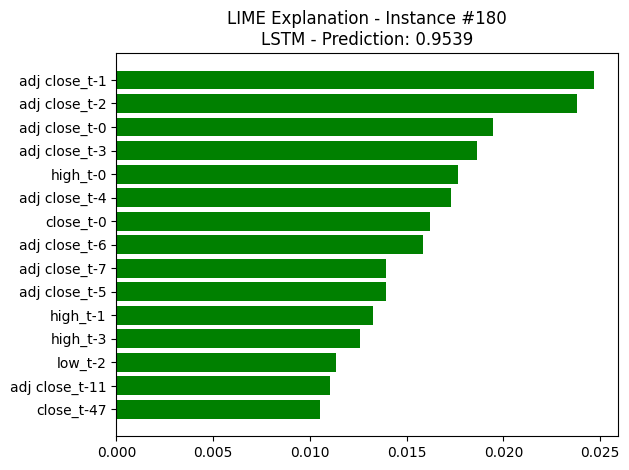


SPIEGAZIONE ISTANZA #181
Valore reale: 1.026067
Predizione modello: 0.959123
Errore assoluto: 0.066944

Generazione spiegazione LIME (con 100 campioni perturbati)...

Top 15 feature più influenti:
----------------------------------------------------------------------
adj close_t-2                                     : +0.023259
adj close_t-1                                     : +0.021941
adj close_t-0                                     : +0.020572
adj close_t-3                                     : +0.019070
close_t-0                                         : +0.016666
close_t-1                                         : +0.015778
high_t-1                                          : +0.015718
adj close_t-6                                     : +0.015451
low_t-1                                           : +0.014938
adj close_t-4                                     : +0.014853
adj close_t-5                                     : +0.014697
close_t-2                                        

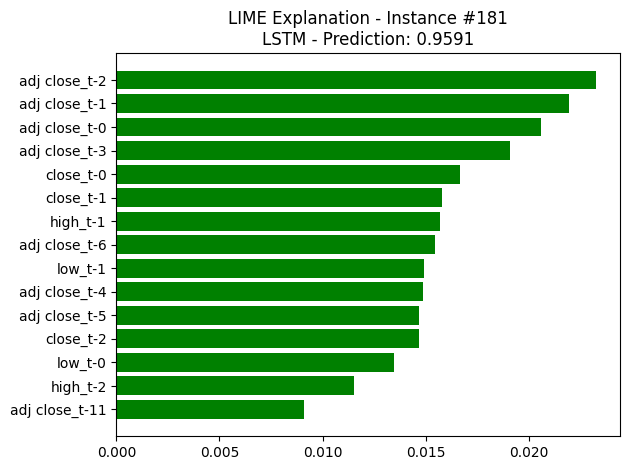


SPIEGAZIONE ISTANZA #182
Valore reale: 1.037018
Predizione modello: 0.960536
Errore assoluto: 0.076482

Generazione spiegazione LIME (con 100 campioni perturbati)...

Top 15 feature più influenti:
----------------------------------------------------------------------
adj close_t-1                                     : +0.023777
adj close_t-0                                     : +0.023524
adj close_t-2                                     : +0.022291
close_t-1                                         : +0.019447
close_t-0                                         : +0.018292
adj close_t-3                                     : +0.017897
adj close_t-5                                     : +0.017783
adj close_t-4                                     : +0.015026
adj close_t-6                                     : +0.015002
high_t-0                                          : +0.014383
low_t-1                                           : +0.014135
open_t-3                                         

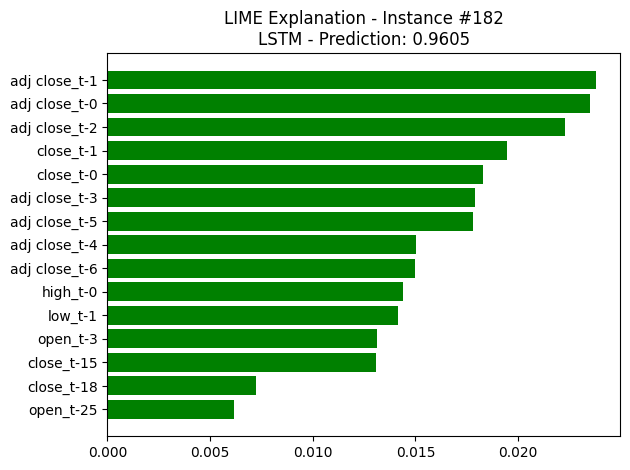


SPIEGAZIONE ISTANZA #183
Valore reale: 1.048923
Predizione modello: 0.974192
Errore assoluto: 0.074731

Generazione spiegazione LIME (con 100 campioni perturbati)...

Top 15 feature più influenti:
----------------------------------------------------------------------
adj close_t-2                                     : +0.024966
adj close_t-3                                     : +0.022072
adj close_t-4                                     : +0.021156
adj close_t-1                                     : +0.020708
adj close_t-0                                     : +0.020321
high_t-1                                          : +0.017968
close_t-1                                         : +0.017300
close_t-0                                         : +0.015430
adj close_t-5                                     : +0.014993
low_t-2                                           : +0.014222
high_t-0                                          : +0.013134
open_t-2                                         

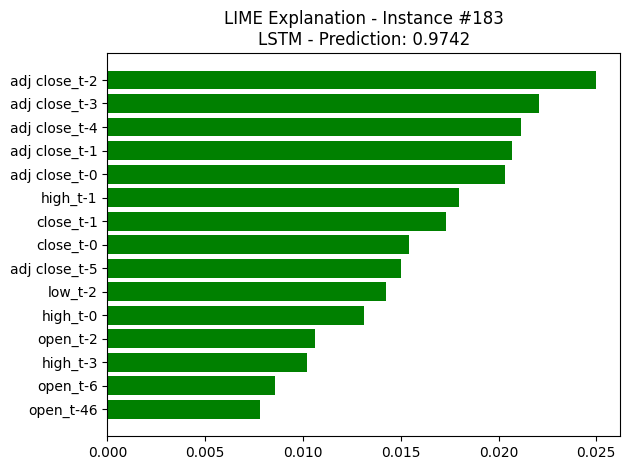


SPIEGAZIONE ISTANZA #184
Valore reale: 1.021628
Predizione modello: 0.987264
Errore assoluto: 0.034364

Generazione spiegazione LIME (con 100 campioni perturbati)...

Top 15 feature più influenti:
----------------------------------------------------------------------
adj close_t-1                                     : +0.025477
adj close_t-2                                     : +0.024215
adj close_t-0                                     : +0.020570
adj close_t-3                                     : +0.020333
adj close_t-4                                     : +0.018980
high_t-0                                          : +0.017671
high_t-1                                          : +0.017132
close_t-2                                         : +0.017051
high_t-2                                          : +0.014629
adj close_t-9                                     : +0.014140
adj close_t-5                                     : +0.012627
adj close_t-49                                   

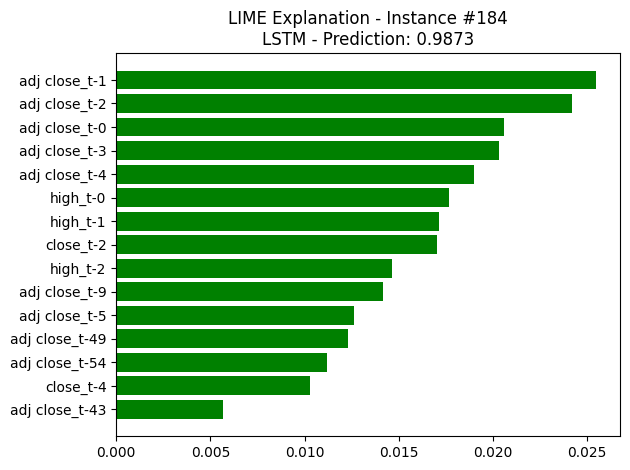


SPIEGAZIONE ISTANZA #185
Valore reale: 1.040046
Predizione modello: 0.985933
Errore assoluto: 0.054113

Generazione spiegazione LIME (con 100 campioni perturbati)...

Top 15 feature più influenti:
----------------------------------------------------------------------
adj close_t-1                                     : +0.027101
adj close_t-2                                     : +0.026212
adj close_t-3                                     : +0.020849
adj close_t-0                                     : +0.019901
close_t-1                                         : +0.018998
adj close_t-4                                     : +0.016414
adj close_t-5                                     : +0.016110
adj close_t-10                                    : +0.015480
open_t-0                                          : +0.015050
adj close_t-7                                     : +0.014776
open_t-1                                          : +0.013872
high_t-0                                         

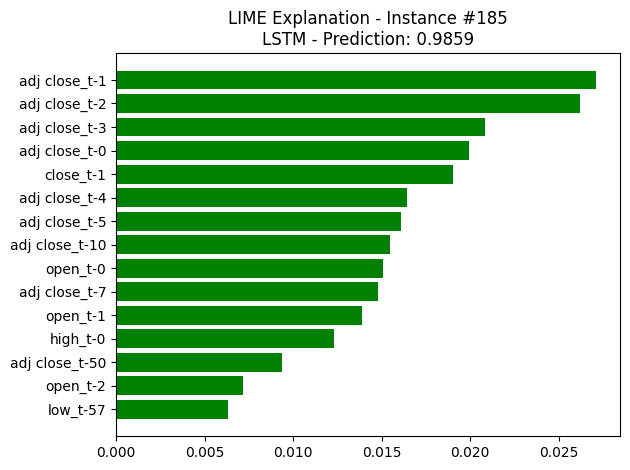


SPIEGAZIONE ISTANZA #186
Valore reale: 1.043987
Predizione modello: 0.988305
Errore assoluto: 0.055682

Generazione spiegazione LIME (con 100 campioni perturbati)...

Top 15 feature più influenti:
----------------------------------------------------------------------
adj close_t-1                                     : +0.023090
close_t-1                                         : +0.021808
adj close_t-6                                     : +0.020975
adj close_t-0                                     : +0.020227
adj close_t-2                                     : +0.018294
adj close_t-5                                     : +0.018240
high_t-1                                          : +0.017598
adj close_t-7                                     : +0.016289
adj close_t-23                                    : +0.015742
high_t-3                                          : +0.013927
high_t-2                                          : +0.013893
close_t-3                                        

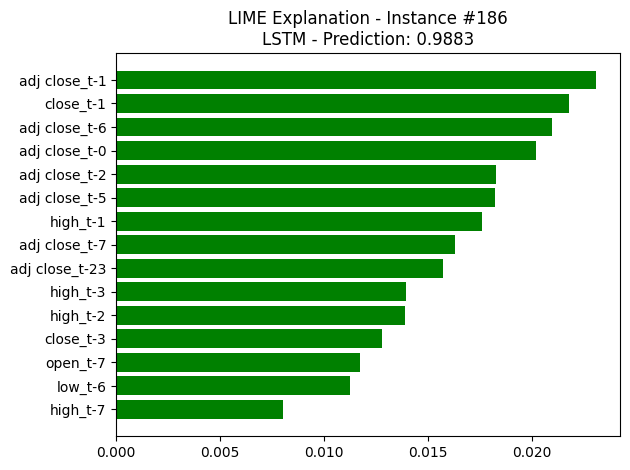


SPIEGAZIONE ISTANZA #187
Valore reale: 1.052283
Predizione modello: 0.993789
Errore assoluto: 0.058494

Generazione spiegazione LIME (con 100 campioni perturbati)...

Top 15 feature più influenti:
----------------------------------------------------------------------
adj close_t-1                                     : +0.024141
adj close_t-3                                     : +0.021536
adj close_t-2                                     : +0.020986
adj close_t-0                                     : +0.020881
adj close_t-5                                     : +0.018292
high_t-1                                          : +0.017184
adj close_t-4                                     : +0.016430
high_t-0                                          : +0.016140
adj close_t-6                                     : +0.014160
low_t-0                                           : +0.013624
adj close_t-7                                     : +0.013614
close_t-0                                        

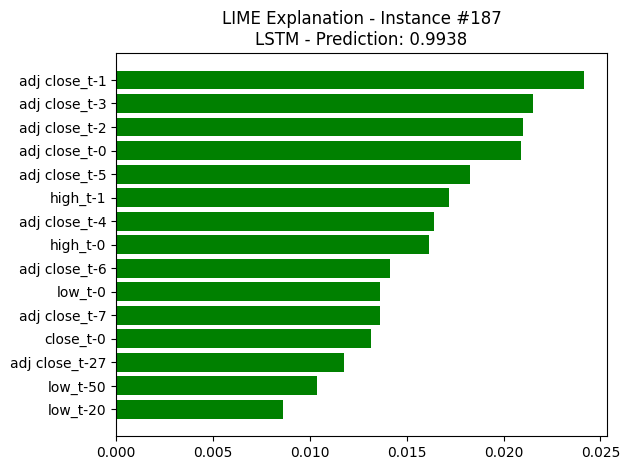


SPIEGAZIONE ISTANZA #188
Valore reale: 1.055850
Predizione modello: 1.000482
Errore assoluto: 0.055369

Generazione spiegazione LIME (con 100 campioni perturbati)...

Top 15 feature più influenti:
----------------------------------------------------------------------
adj close_t-2                                     : +0.023006
adj close_t-1                                     : +0.021947
adj close_t-5                                     : +0.019946
adj close_t-4                                     : +0.019405
adj close_t-0                                     : +0.019219
adj close_t-3                                     : +0.018724
close_t-0                                         : +0.017240
close_t-1                                         : +0.017029
adj close_t-7                                     : +0.016577
high_t-0                                          : +0.015795
close_t-2                                         : +0.014979
low_t-0                                          

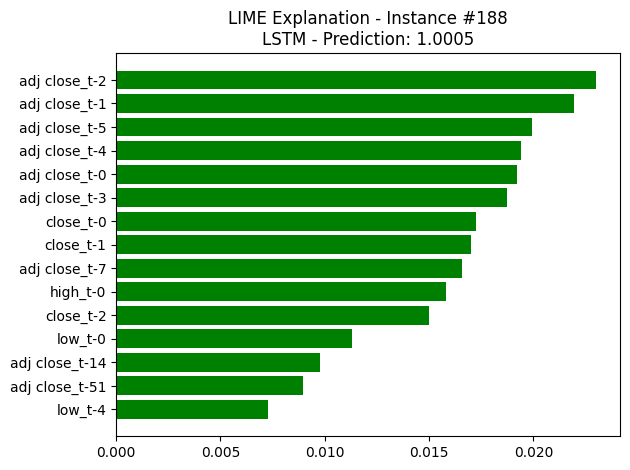


SPIEGAZIONE ISTANZA #189
Valore reale: 1.056597
Predizione modello: 1.003906
Errore assoluto: 0.052691

Generazione spiegazione LIME (con 100 campioni perturbati)...

Top 15 feature più influenti:
----------------------------------------------------------------------
close_t-1                                         : +0.020429
adj close_t-1                                     : +0.020126
adj close_t-7                                     : +0.019694
adj close_t-2                                     : +0.019406
adj close_t-4                                     : +0.017946
low_t-1                                           : +0.017921
adj close_t-5                                     : +0.017510
adj close_t-0                                     : +0.016532
adj close_t-33                                    : +0.016332
high_t-1                                          : +0.014904
close_t-0                                         : +0.013696
open_t-1                                         

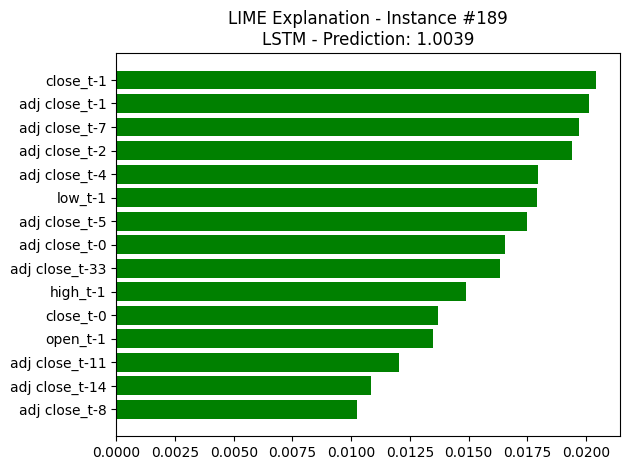


AGGREGAZIONE RISULTATI LIME

Top 20 feature più importanti (media su 10 istanze):
----------------------------------------------------------------------
 1. adj close_t-1                                     : 0.023301
 2. adj close_t-2                                     : 0.022643
 3. adj close_t-0                                     : 0.020121
 4. adj close_t-3                                     : 0.019887
 5. close_t-1                                         : 0.018684
 6. adj close_t-4                                     : 0.017499
 7. adj close_t-5                                     : 0.016414
 8. adj close_t-33                                    : 0.016332
 9. adj close_t-6                                     : 0.016289
10. high_t-1                                          : 0.016254
11. adj close_t-7                                     : 0.015817
12. close_t-0                                         : 0.015817
13. adj close_t-23                                    : 0.015742
1

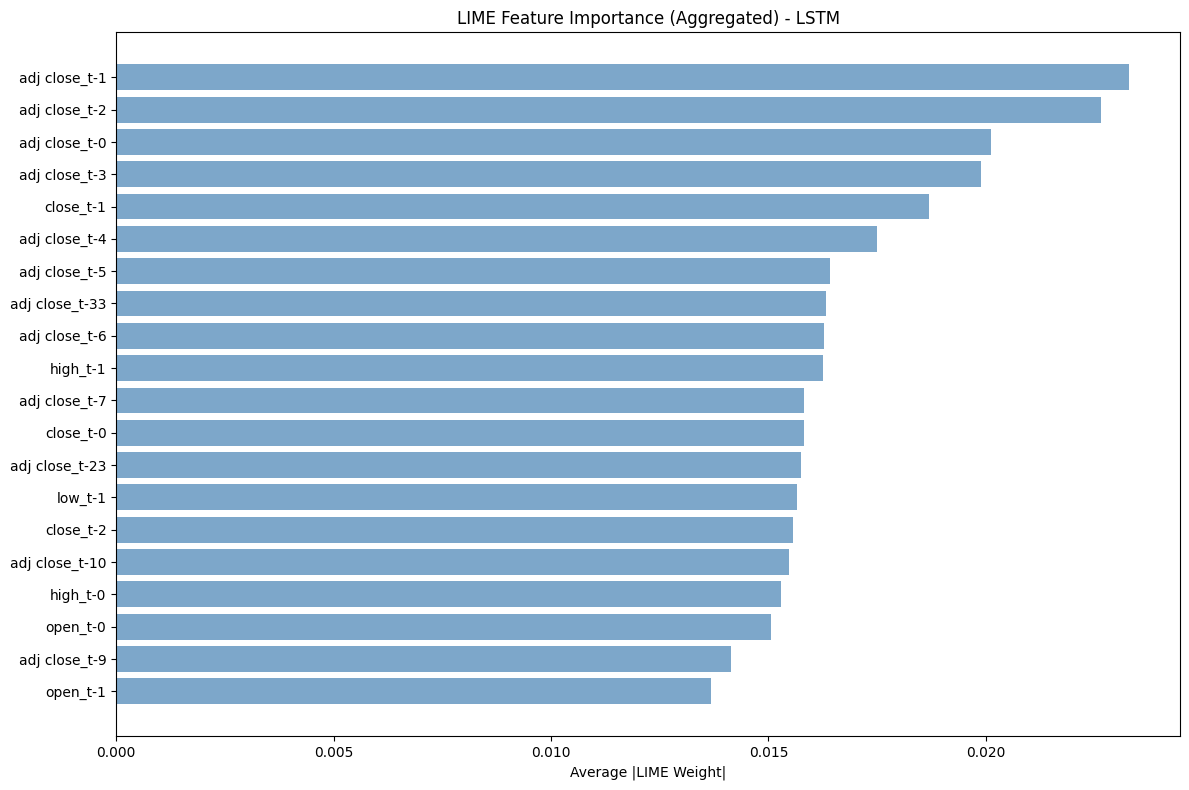


Aggregazione per feature base (sommando su tutti i timestep):
----------------------------------------------------------------------
1. adj close      : 0.304182
2. close          : 0.103995
3. low            : 0.085104
4. open           : 0.084963
5. high           : 0.065191
6. volume         : 0.000000
----------------------------------------------------------------------


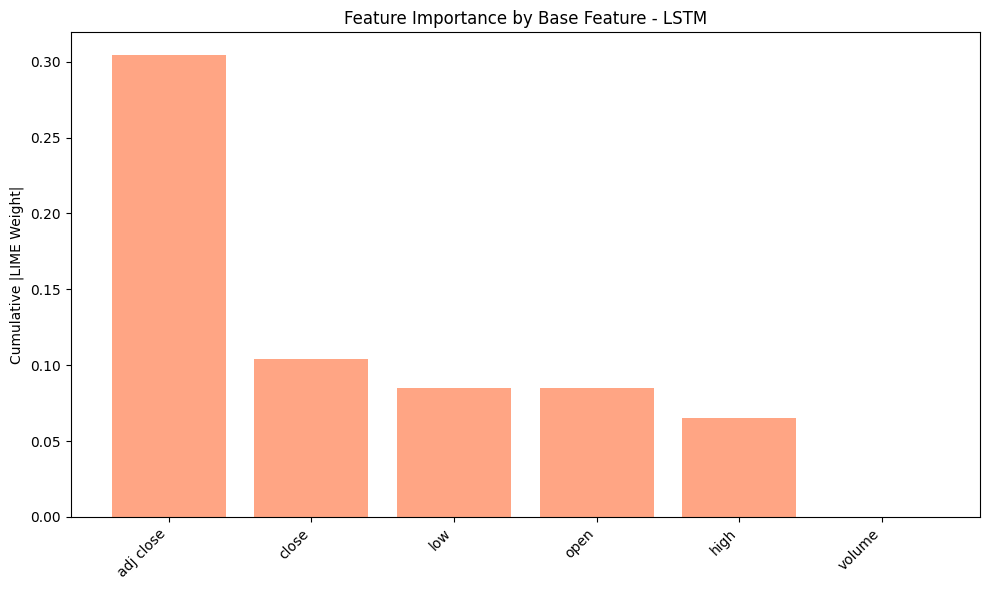


CREAZIONE HEATMAP TEMPORALE


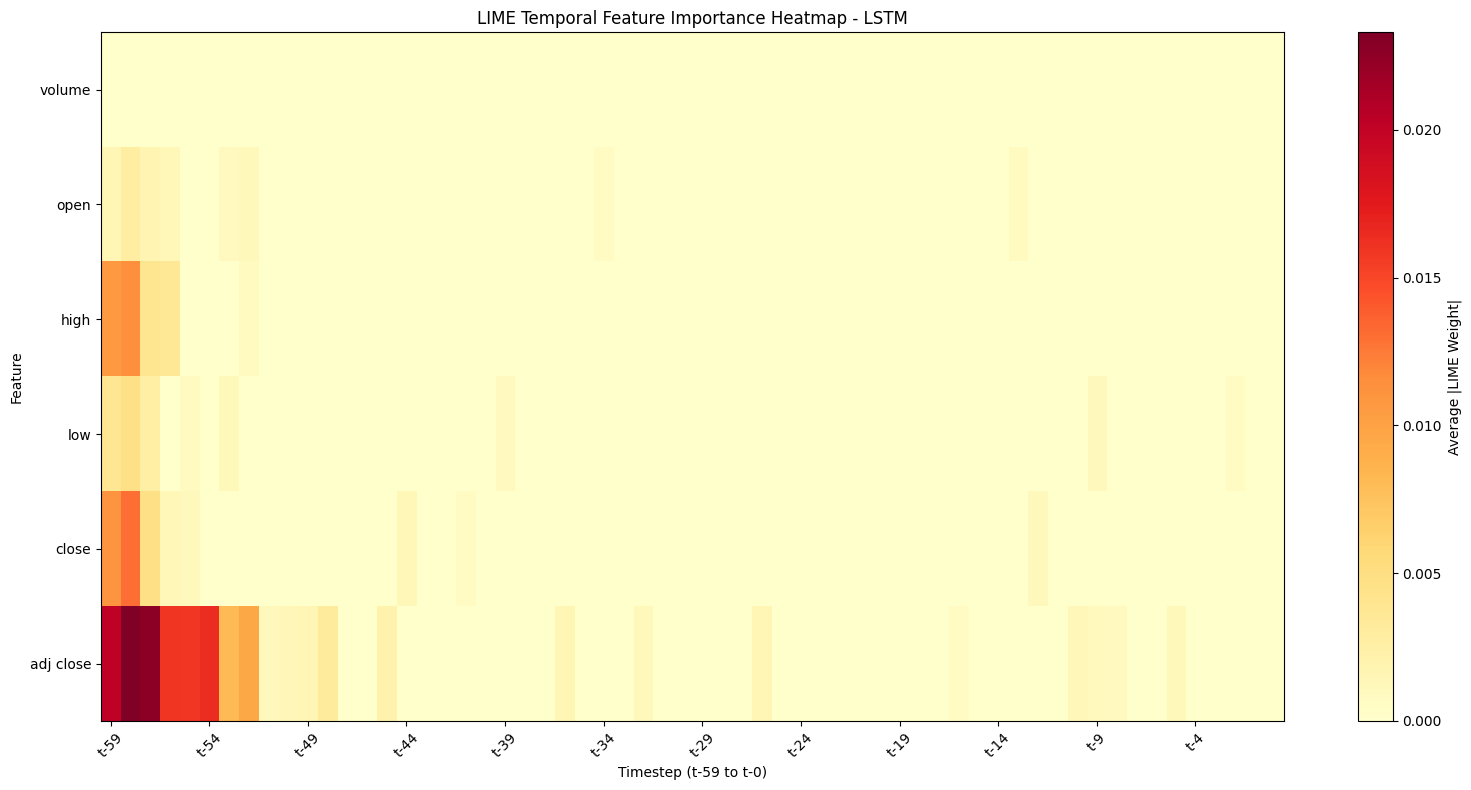


Top 10 timestep più importanti:
 1. t-58: 0.055195
 2. t-59: 0.047244
 3. t-57: 0.035653
 4. t-56: 0.022176
 5. t-55: 0.017510
 6. t-54: 0.016414
 7. t-52: 0.011467
 8. t-53: 0.010130
 9. t-48: 0.003223
10. t-45: 0.002063

ANALISI LIME COMPLETATA!

File generati:
  - lime_instance_*_lstm.png (spiegazioni individuali)
  - lime_aggregated_lstm.png (importanza aggregata)
  - lime_base_features_lstm.png (importanza per feature)
  - lime_temporal_heatmap_lstm.png (heatmap temporale)


In [8]:
import lime
from lime import lime_tabular
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd
from pathlib import Path


class Config:
    """Configurazione centralizzata per l'analisi LIME"""
    MODEL_PATH = "../models/price_models/best_lstm_spy_model.keras" 
    #MODEL_PATH = "../models/price_models/best_decision_tree_spy.pkl"
    
    X_TRAIN_PATH = "C:/Users/angel/OneDrive/Desktop/ProgettoMeDL/Financial_Forecasting_XAI/data_split_titolo/X_train.npy"
    X_TEST_PATH = "C:/Users/angel/OneDrive/Desktop/ProgettoMeDL/Financial_Forecasting_XAI/data_split_titolo/X_test.npy"
    Y_TEST_PATH = "C:/Users/angel/OneDrive/Desktop/ProgettoMeDL/Financial_Forecasting_XAI/data_split_titolo/y_test.npy"
    
    # Nomi delle feature
    FEATURES_TECHNICAL = ['volume', 'open', 'high', 'low', 'close', 'adj close']
    FEATURES_WITH_SENTIMENT = ['volume', 'open', 'high', 'low', 'close', 'adj close', 'sentiment_score']
    
    # Parametri LIME
    N_SAMPLES = 100           
    N_FEATURES_TO_SHOW = 15    
    N_INSTANCES_TO_EXPLAIN = 10  
    N_TIMESTEPS = 60


def load_data(config):
    """Carica i dati di training e test"""
    print(f"Caricamento dati...")
    X_train = np.load(config.X_TRAIN_PATH)
    X_test = np.load(config.X_TEST_PATH)
    
    # Carica y_test se disponibile (opzionale)
    try:
        y_test = np.load(config.Y_TEST_PATH)
        print(f"Shape dati - Train: {X_train.shape}, Test: {X_test.shape}, y_test: {y_test.shape}")
    except:
        y_test = None
        print(f"Shape dati - Train: {X_train.shape}, Test: {X_test.shape}")
        print("y_test non trovato (opzionale)")
    
    return X_train, X_test, y_test


def identify_model_type(model_path, model):
    """Identifica il tipo di modello e le feature attese"""
    if model_path.endswith('.pkl'):
        # Decision Tree
        model_type = 'tree'
        expected_features = int(model.n_features_in_ / 60)
        input_shape = (60, expected_features)
    else:
        # Keras (LSTM o CNN)
        input_shape = model.input_shape
        
        if len(input_shape) == 3:  # (Batch, Steps, Features)
            model_type = 'lstm'
            expected_features = input_shape[-1]
        elif len(input_shape) == 4:  # (Batch, Steps, Features, Channels)
            model_type = 'cnn'
            expected_features = input_shape[-2]
        else:
            raise ValueError(f"Shape modello sconosciuta: {input_shape}")
    
    print(f"Tipo modello: {model_type.upper()}")
    print(f"Feature attese: {expected_features}")
    print(f"Input shape: {input_shape}")
    
    return model_type, expected_features, input_shape


def prepare_data(X_train, X_test, expected_features, config):
    """Prepara i dati in base al numero di feature attese"""
    if expected_features == 6:
        print(">>> MODALITÀ: SOLO DATI TECNICI (Rimozione Sentiment)")
        X_train_ready = X_train[:, :, :-1]
        X_test_ready = X_test[:, :, :-1]
        feature_names = config.FEATURES_TECHNICAL
    elif expected_features == 7:
        print(">>> MODALITÀ: TECNICI + SENTIMENT")
        X_train_ready = X_train
        X_test_ready = X_test
        feature_names = config.FEATURES_WITH_SENTIMENT
    else:
        raise ValueError(f"Numero di feature non supportato: {expected_features}")
    
    print(f"Feature utilizzate: {feature_names}")
    
    return X_train_ready, X_test_ready, feature_names


def create_feature_names_temporal(feature_names, n_timesteps):
    temporal_names = []
    for t in range(n_timesteps - 1, -1, -1):
        for feat in feature_names:
            temporal_names.append(f"{feat}_t-{t}")
    return temporal_names


def create_predict_function(model, model_type, expected_features, n_timesteps):
    if model_type == 'tree':
        # Decision Tree accetta già dati piatti
        def predict_fn(data_flat):
            return model.predict(data_flat)
    
    elif model_type == 'lstm':
        # LSTM richiede (samples, timesteps, features)
        def predict_fn(data_flat):
            # Reshape da (samples, timesteps*features) a (samples, timesteps, features)
            data_3d = data_flat.reshape(-1, n_timesteps, expected_features)
            predictions = model.predict(data_3d, verbose=0)
            return predictions.flatten()
    
    elif model_type == 'cnn':
        # CNN richiede (samples, timesteps, features, channels)
        def predict_fn(data_flat):
            # Reshape da (samples, timesteps*features) a (samples, timesteps, features, 1)
            data_3d = data_flat.reshape(-1, n_timesteps, expected_features)
            data_4d = np.expand_dims(data_3d, axis=-1)
            predictions = model.predict(data_4d, verbose=0)
            return predictions.flatten()
    
    else:
        raise ValueError(f"Tipo di modello non supportato: {model_type}")
    
    return predict_fn


def run_lime_analysis(model, model_type, X_train_ready, X_test_ready, feature_names, 
                      y_test, config, instances_to_explain=None):

    
    print("\n" + "="*70)
    print("INIZIALIZZAZIONE LIME EXPLAINER")
    print("="*70)
    
    n_timesteps = config.N_TIMESTEPS
    n_features = len(feature_names)
    
    # Appiattimento dei dati
    print("Appiattimento dati per LIME...")
    X_train_flat = X_train_ready.reshape(X_train_ready.shape[0], -1)
    X_test_flat = X_test_ready.reshape(X_test_ready.shape[0], -1)
    
    print(f"Shape training set appiattito: {X_train_flat.shape}")
    print(f"Shape test set appiattito: {X_test_flat.shape}")
    
    # Creazione nomi feature temporali
    temporal_feature_names = create_feature_names_temporal(feature_names, n_timesteps)
    print(f"Feature temporali create: {len(temporal_feature_names)}")
    
    # Creazione funzione di predizione
    predict_fn = create_predict_function(model, model_type, n_features, n_timesteps)
    
    # Test della funzione di predizione
    print("\nTest funzione di predizione...")
    test_pred = predict_fn(X_train_flat[:2])
    print(f"Predizioni di test: {test_pred}")
    
    # Inizializzazione LIME Explainer
    print("\nInizializzazione LimeTabularExplainer...")
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_train_flat,
        mode='regression',
        feature_names=temporal_feature_names,
        verbose=False,
        discretize_continuous=False
    )
    
    # Selezione istanze da spiegare
    if instances_to_explain is None:
        # Usa gli ultimi N del test set
        instances_to_explain = list(range(
            len(X_test_flat) - config.N_INSTANCES_TO_EXPLAIN, 
            len(X_test_flat)
        ))
    
    print(f"\nIstanze da spiegare: {instances_to_explain}")
    
    # Analisi di ogni istanza
    explanations = []
    
    for idx in instances_to_explain:
        print("\n" + "="*70)
        print(f"SPIEGAZIONE ISTANZA #{idx}")
        print("="*70)
        
        instance = X_test_flat[idx]
        
        # Valore reale se disponibile
        if y_test is not None:
            actual_value = y_test[idx]
            print(f"Valore reale: {actual_value:.6f}")
        
        # Predizione del modello
        prediction = predict_fn(instance.reshape(1, -1))[0]
        print(f"Predizione modello: {prediction:.6f}")
        
        if y_test is not None:
            error = abs(prediction - actual_value)
            print(f"Errore assoluto: {error:.6f}")
        
        # Generazione spiegazione LIME
        print(f"\nGenerazione spiegazione LIME (con {config.N_SAMPLES} campioni perturbati)...")
        exp = explainer.explain_instance(
            instance, 
            predict_fn, 
            num_features=config.N_FEATURES_TO_SHOW,
            num_samples=config.N_SAMPLES
        )
        
        explanations.append(exp)
        
        # Stampa top feature
        print(f"\nTop {config.N_FEATURES_TO_SHOW} feature più influenti:")
        print("-" * 70)
        for feat, weight in exp.as_list():
            print(f"{feat:50s}: {weight:+.6f}")
        print("-" * 70)
        
        # Plot individuale
        fig = exp.as_pyplot_figure()
        plt.title(f"LIME Explanation - Instance #{idx}\n{model_type.upper()} - Prediction: {prediction:.4f}")
        plt.tight_layout()
        plt.savefig(f'lime_instance_{idx}_{model_type}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    return explanations, instances_to_explain


def aggregate_lime_results(explanations, feature_names, n_timesteps, model_type, config):
    """
    Aggrega i risultati LIME per vedere l'importanza media delle feature
    """
    
    print("\n" + "="*70)
    print("AGGREGAZIONE RISULTATI LIME")
    print("="*70)
    
    # Dizionario per accumulare pesi per ogni feature temporale
    feature_weights = {}
    
    for exp in explanations:
        for feat, weight in exp.as_list():
            if feat not in feature_weights:
                feature_weights[feat] = []
            feature_weights[feat].append(abs(weight))
    
    # Calcola media dei pesi assoluti
    feature_importance = {feat: np.mean(weights) for feat, weights in feature_weights.items()}
    
    # Ordina per importanza
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    
    # Top N feature
    top_n = min(20, len(sorted_features))
    top_features = sorted_features[:top_n]
    
    print(f"\nTop {top_n} feature più importanti (media su {len(explanations)} istanze):")
    print("-" * 70)
    for rank, (feat, importance) in enumerate(top_features, 1):
        print(f"{rank:2d}. {feat:50s}: {importance:.6f}")
    print("-" * 70)
    
    # Plot aggregato
    features_list = [f[0] for f in top_features]
    importance_list = [f[1] for f in top_features]
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(features_list)), importance_list, color='steelblue', alpha=0.7)
    plt.yticks(range(len(features_list)), features_list)
    plt.xlabel('Average |LIME Weight|')
    plt.title(f'LIME Feature Importance (Aggregated) - {model_type.upper()}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(f'lime_aggregated_{model_type}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Aggregazione per feature base (ignorando timestep)
    print("\nAggregazione per feature base (sommando su tutti i timestep):")
    print("-" * 70)
    
    base_feature_importance = {feat: 0.0 for feat in feature_names}
    
    for feat, importance in feature_importance.items():
        # Estrai il nome base della feature (prima di '_t-')
        base_feat = feat.split('_t-')[0]
        if base_feat in base_feature_importance:
            base_feature_importance[base_feat] += importance
    
    # Ordina
    sorted_base = sorted(base_feature_importance.items(), key=lambda x: x[1], reverse=True)
    
    for rank, (feat, importance) in enumerate(sorted_base, 1):
        print(f"{rank}. {feat:15s}: {importance:.6f}")
    print("-" * 70)
    
    # Plot aggregazione base
    plt.figure(figsize=(10, 6))
    base_feats = [f[0] for f in sorted_base]
    base_importance = [f[1] for f in sorted_base]
    
    plt.bar(range(len(base_feats)), base_importance, color='coral', alpha=0.7)
    plt.xticks(range(len(base_feats)), base_feats, rotation=45, ha='right')
    plt.ylabel('Cumulative |LIME Weight|')
    plt.title(f'Feature Importance by Base Feature - {model_type.upper()}')
    plt.tight_layout()
    plt.savefig(f'lime_base_features_{model_type}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return feature_importance, base_feature_importance


def create_temporal_heatmap(explanations, feature_names, n_timesteps, model_type):
    """
    Crea una heatmap che mostra l'importanza di ogni feature in ogni timestep
    """
    
    print("\n" + "="*70)
    print("CREAZIONE HEATMAP TEMPORALE")
    print("="*70)
    
    # Matrice (features x timesteps)
    importance_matrix = np.zeros((len(feature_names), n_timesteps))
    
    for exp in explanations:
        for feat, weight in exp.as_list():
            # Estrai nome base e timestep
            parts = feat.split('_t-')
            if len(parts) == 2:
                base_feat = parts[0]
                timestep = int(parts[1])
                
                if base_feat in feature_names:
                    feat_idx = feature_names.index(base_feat)
                    importance_matrix[feat_idx, timestep] += abs(weight)
    
    # Media su tutte le spiegazioni
    importance_matrix /= len(explanations)
    
    # Plot heatmap
    plt.figure(figsize=(16, 8))
    plt.imshow(importance_matrix, aspect='auto', cmap='YlOrRd', interpolation='nearest')
    plt.colorbar(label='Average |LIME Weight|')
    plt.yticks(range(len(feature_names)), feature_names)
    plt.xlabel('Timestep (t-59 to t-0)')
    plt.ylabel('Feature')
    plt.title(f'LIME Temporal Feature Importance Heatmap - {model_type.upper()}')
    
    # Aggiungi etichette timestep ogni 5 step
    xtick_positions = list(range(0, n_timesteps, 5))
    xtick_labels = [f't-{n_timesteps-1-i}' for i in xtick_positions]
    plt.xticks(xtick_positions, xtick_labels, rotation=45)
    
    plt.tight_layout()
    plt.savefig(f'lime_temporal_heatmap_{model_type}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Trova timestep più importanti
    timestep_importance = np.sum(importance_matrix, axis=0)
    top_timesteps = np.argsort(timestep_importance)[-10:][::-1]
    
    print("\nTop 10 timestep più importanti:")
    for rank, ts in enumerate(top_timesteps, 1):
        print(f"{rank:2d}. t-{n_timesteps-1-ts:2d}: {timestep_importance[ts]:.6f}")
    
    return importance_matrix


def main():
    """Funzione principale"""
    config = Config()
    
    print("="*70)
    print("LIME ANALYSIS - FINANCIAL FORECASTING MODELS")
    print("="*70)
    
    # 1. Caricamento dati
    X_train, X_test, y_test = load_data(config)
    
    # 2. Caricamento modello
    print(f"\nCaricamento modello: {os.path.basename(config.MODEL_PATH)}...")
    if config.MODEL_PATH.endswith('.pkl'):
        model = joblib.load(config.MODEL_PATH)
    else:
        model = load_model(config.MODEL_PATH)
    
    # 3. Identificazione tipo modello
    model_type, expected_features, input_shape = identify_model_type(config.MODEL_PATH, model)
    
    # 4. Preparazione dati
    X_train_ready, X_test_ready, feature_names = prepare_data(
        X_train, X_test, expected_features, config
    )
    
    # 5. Esecuzione LIME
    explanations, instances = run_lime_analysis(
        model, model_type, X_train_ready, X_test_ready, 
        feature_names, y_test, config
    )
    
    # 6. Aggregazione risultati
    feature_importance, base_importance = aggregate_lime_results(
        explanations, feature_names, config.N_TIMESTEPS, model_type, config
    )
    
    # 7. Heatmap temporale
    importance_matrix = create_temporal_heatmap(
        explanations, feature_names, config.N_TIMESTEPS, model_type
    )
    
    print("\n" + "="*70)
    print("ANALISI LIME COMPLETATA!")
    print("="*70)
    print(f"\nFile generati:")
    print(f"  - lime_instance_*_{model_type}.png (spiegazioni individuali)")
    print(f"  - lime_aggregated_{model_type}.png (importanza aggregata)")
    print(f"  - lime_base_features_{model_type}.png (importanza per feature)")
    print(f"  - lime_temporal_heatmap_{model_type}.png (heatmap temporale)")
    print("="*70)
    
    return explanations, feature_importance, base_importance, importance_matrix


if __name__ == "__main__":
    explanations, feature_imp, base_imp, imp_matrix = main()